<a href="https://colab.research.google.com/github/pizzapuppies/Youssif_FYP_Code/blob/main/SD_hyper_tuned_concentration_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q -U keras-tuner
from google.colab import drive
import pandas as pd 
import os
import tensorflow as tf
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from tensorflow import keras
import sys
import keras_tuner as kt
drive.mount('/content/gdrive')
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00
Mounted at /content/gdrive


#Data preprocessing

In [ ]:
#@title reading the data from google drive
data_list = []
data = {}
with open("/content/gdrive/My Drive/balanced_data.csv","r") as rfile:
  reader  = csv.reader(rfile)
  for row in reader:
   label = row[0] if "n" not in row[0] else "n"
   if label not in data.keys():
    data[label] = []
   
   real,imag = list(map(float,row[1:51])),list(map(float,row[51:]))
   temp  = []
   for j in range(len(imag)):
     temp.append([real[j],imag[j]])
   data[label].append(temp)

data_list.append(data)

"""# VAE data
v_data = {}
with open("/content/gdrive/My Drive/vae100_data.csv",'r') as rfile:
  reader = csv.reader(rfile)
  for row in reader:
   label = row[0] if "n" not in row[0] else "n"
   if label not in v_data.keys():
    v_data[label] = []
   
   real,imag = list(map(float,row[1:51])),list(map(float,row[51:]))
   temp  = []
   for j in range(len(imag)):
     temp.append([real[j],imag[j]])
   v_data[label].append(temp)

lim = 100
for key in v_data.keys():
  print(key,len(v_data[key]))
  temp = v_data[key]
  while len(temp) != lim:
    if len(temp) < lim:
      r = random.randint(0,len(v_data[key])-1)
      temp.append(v_data[key][r])
    else:
      r = random.randint(0,len(v_data[key])-1)
      temp.pop(r)
  v_data[key] = temp
print(v_data.keys())

data_list.append(v_data)"""







"""# get the fake GAN data and fix the imbalance
s_data = {}
with open("/content/gdrive/My Drive/gan100_data.csv","r") as rfile:
  reader  = csv.reader(rfile)
  for row in reader:
    label = row[0] if "n" not in row[0] else "n"
    if label not in s_data.keys():
      s_data[label] = []
    
    real,imag = list(map(float,row[1:51])),list(map(float,row[51:]))
    temp  = []
    for j in range(len(real)):
      temp.append([real[j],imag[j]])
    s_data[label].append(temp)


lim = 100
for key in s_data.keys():
  print(key,len(s_data[key]))
  temp = s_data[key]
  while len(temp) != lim:
    if len(temp) < lim:
      r = random.randint(0,len(s_data[key])-1)
      temp.append(s_data[key][r])
    else:
      r = random.randint(0,len(s_data[key])-1)
      temp.pop(r)
  s_data[key] = temp

data_list.append(s_data)"""





print(f"we have {np.array(data['p1']).shape} row of data")

we have (70, 50, 2) row of data


In [ ]:
# shuffle
#[[],[],[],[],..]

x = []
y = []
for Data in data_list:
  for key in Data.keys():
    for test in Data[key]:
      y.append(key)
      x.append(test)
X = x
temp = list(zip(X, y))
random.shuffle(temp)
X,y = zip(*temp)
X,y = list(X), list(y)


X = np.array(X)

In [ ]:
#@title one hot encoding Y

mapping = {}
codes = list(set(y))
#codes = ["p0.5","p1","p2","p4","p8","p16","p32","n"]
l = len(codes)

for i in range(l):
  li = [0]*l
  
  li[i] = 1
  
  mapping[codes[i]] = np.array(li)

temp = []
for i in y:
  if "n" in i:
    temp.append(mapping["n"])  
  else:
    temp.append(mapping[i])

y = np.array(temp)

print("The shape of Y is",y.shape)

The shape of Y is (560, 8)


# using the model

In [ ]:
#@title model builder funtion
def model_builder(hp):
  model = tf.keras.models.Sequential()
  model.add(keras.layers.Dense(128,         #Number of nodes
                        input_shape=(50,2), #Number of input variables
                        name='Hidden-Layer-1', #Logical name
                        activation='relu'))    #activation function

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  
  #Add a second hidden layer
  model.add(keras.layers.Dense(units=hp_units,
                                name='Hidden-Layer-2',
                                activation='relu',
                                ))

  

  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-3',
                                activation='relu'))



  #Add a second hidden layer
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-4',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-5',
                              activation='relu'))
  
  model.add(keras.layers.Dense(128,
                                name='Hidden-Layer-6',
                              activation='relu'))

  model.add(tf.keras.layers.Flatten())
  model.add(keras.layers.Dense(8,
                             name='Output-Layer',
                             activation='softmax'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  
  

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

def learn_test(X_train,Y_train,X_test,Y_test):
  

  tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

  tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  #print(f
  """
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  )"""

 # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2)

  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

  hypermodel = tuner.hypermodel.build(best_hps)

  # Retrain the model
  hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

  eval_result = hypermodel.evaluate(X_test, Y_test)
  print("[test loss, test accuracy]:", eval_result)
  return eval_result[1],history


In [ ]:
from sklearn.model_selection import KFold
x = np.array(x)
y = np.array(y)
n_split=15

li = []
hist = []
for train_index,test_index in KFold(n_split).split(x):
  
  x_train,x_test=x[train_index],x[test_index]
  y_train,y_test=y[train_index],y[test_index]
  xa,his = learn_test(x_train,y_train,x_test,y_test)
  li.append(round(xa*100))
  hist.append(his)

Trial 43 Complete [00h 00m 05s]
val_accuracy: 0.17142857611179352

Best val_accuracy So Far: 0.20952381193637848
Total elapsed time: 00h 03m 17s
Epoch 1/100
14/14 [==============================] - 3s 61ms/step - loss: 42.3418 - accuracy: 0.1007 - val_loss: 8.8318 - val_accuracy: 0.2000
Epoch 2/100
14/14 [==============================] - 0s 35ms/step - loss: 13.4937 - accuracy: 0.1247 - val_loss: 10.0771 - val_accuracy: 0.1143
Epoch 3/100
14/14 [==============================] - 0s 34ms/step - loss: 7.9091 - accuracy: 0.1223 - val_loss: 5.4231 - val_accuracy: 0.1524
Epoch 4/100
14/14 [==============================] - 0s 33ms/step - loss: 6.1617 - accuracy: 0.1151 - val_loss: 4.2021 - val_accuracy: 0.2000
Epoch 5/100
14/14 [==============================] - 0s 32ms/step - loss: 4.6661 - accuracy: 0.1415 - val_loss: 3.2874 - val_accuracy: 0.1333
Epoch 6/100
14/14 [==============================] - 0s 33ms/step - loss: 4.4423 - accuracy: 0.1391 - val_loss: 5.3156 - val_accuracy: 0.1048


In [ ]:
print("The max accuarcy is",max(li))
print("The average accuary is ",sum(li)//len(li))
print(li) 


The max accuarcy is 35
The average accuary is  15
[13, 16, 11, 18, 13, 16, 8, 16, 11, 16, 11, 8, 14, 35, 22]


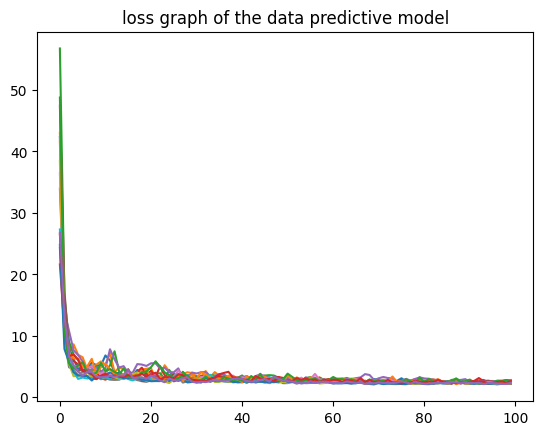

In [ ]:
from matplotlib import pyplot as plt
for obj in hist:
  i  =obj.history["loss"]
  plt.plot(i)
plt.title("loss graph of the data predictive model")
plt.show()